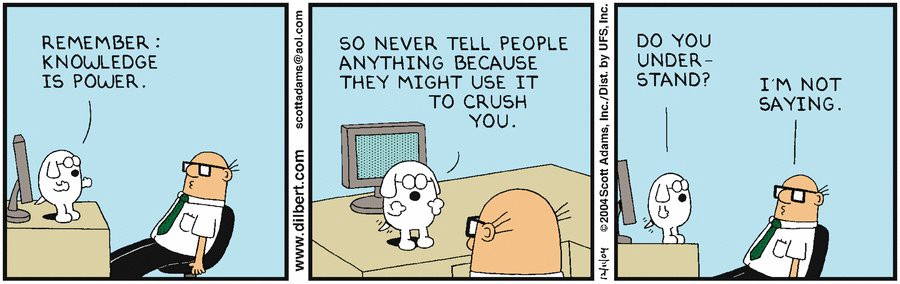

# What is Transfer Learning ? 
Given a source domain $D_s$ and its corresponding task $ T_s $ , where the learned function $f_s$ can be interpreted as some knowledge obtained in $D_s$ and $T_s$. Our goal is to get the target predictive function $f_t$ for target $T_t$ task  with target domain $D_t$. Transfer learning aims to help improve the performance of $f_t$  by utilizing the knowledge $f_t$ , where $D_s \not= D_t$ or $T_s \not= T_t$. In short, transfer learning can be simply denoted as $$ D_s,T_s \rightarrow D_t, T_t$$



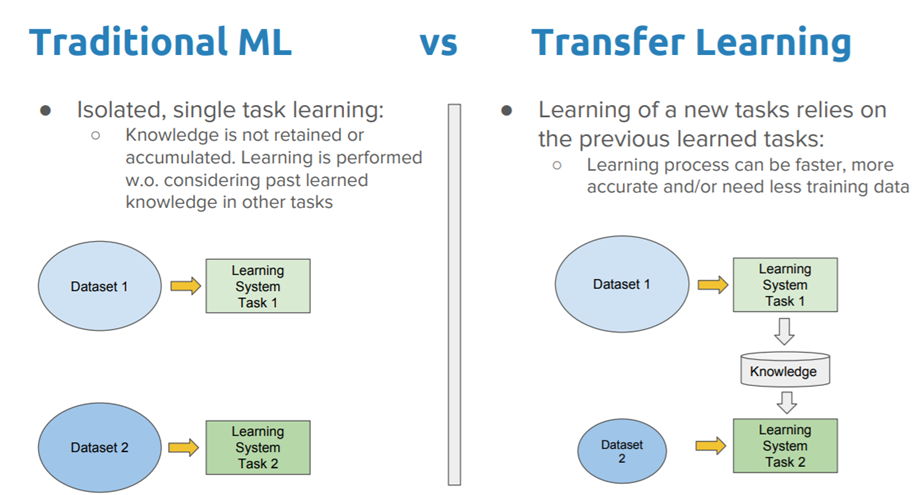

*The intuition behind transfer learning for image classification is that if a model is trained on a large and general enough dataset, this model will effectively serve as a generic model of the visual world. We can then take advantage of these learned feature maps without having to start from scratch by training a large model on a large dataset.*

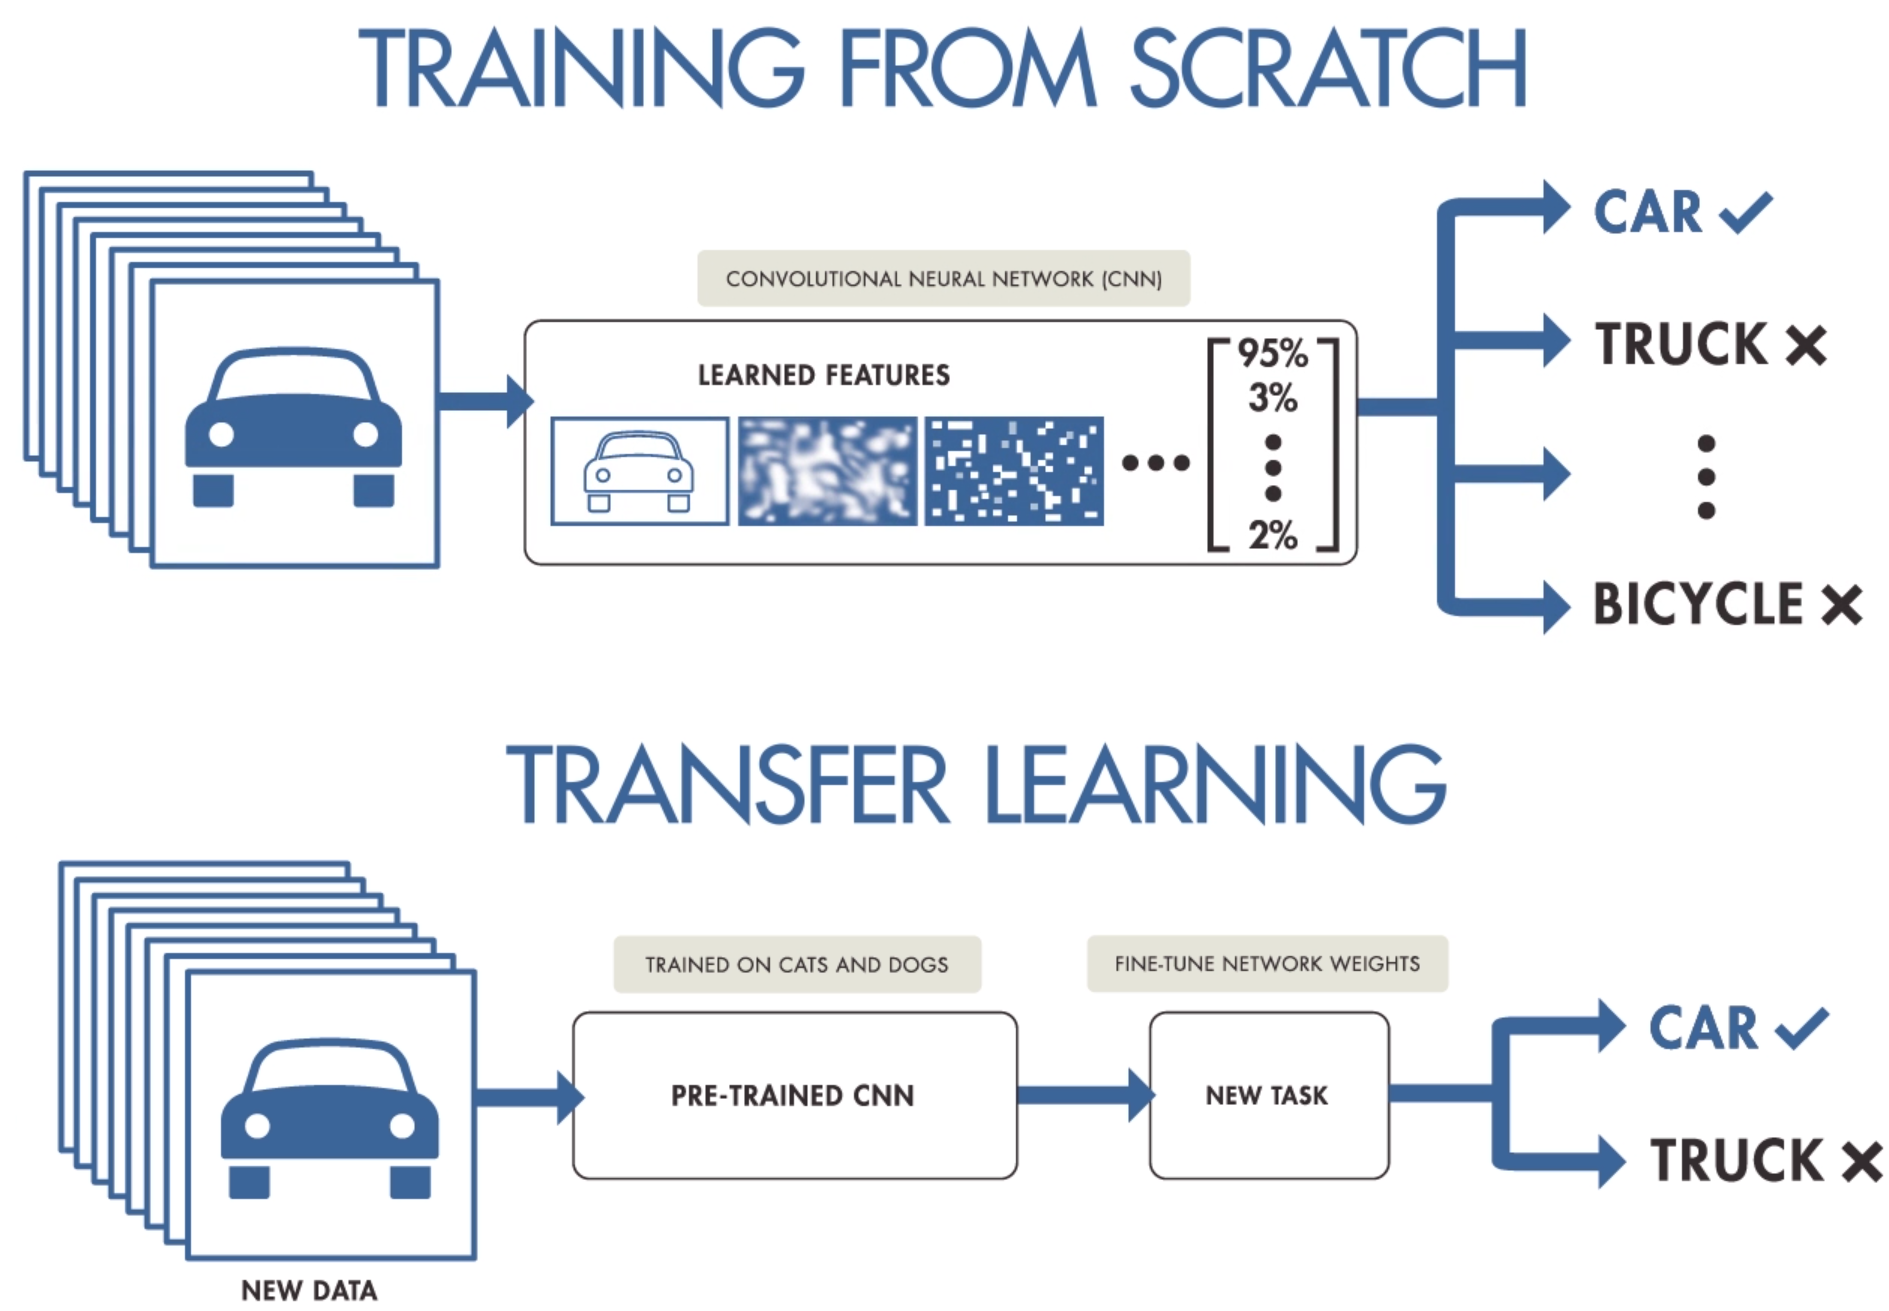

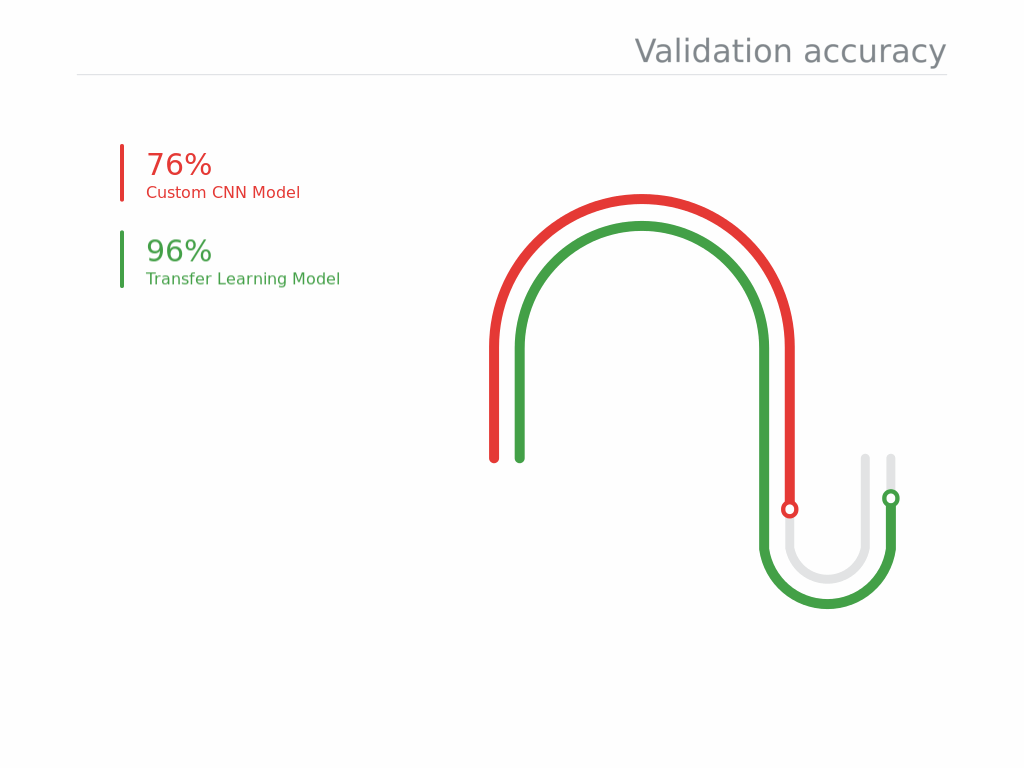


Transfer Learning for Computer Vision 
=====================================


These two major transfer learning scenarios look as follows:

-  **Finetuning the convnet**: Instead of random initialization, we
   initialize the network with a pretrained network, like the one that is
   trained on imagenet 1000 dataset. Rest of the training looks as
   usual.
-  **ConvNet as fixed feature extractor**: Here, we will freeze the weights
   for all of the network except that of the final fully connected
   layer. This last fully connected layer is replaced with a new one
   with random weights and only this layer is trained.




In [ ]:
%matplotlib inline

In [ ]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import requests

plt.ion()   # interactive mode

Downloading Dataset
---------

We will use torchvision and torch.utils.data packages for loading the
data.

The problem we're going to solve today is to train a model to classify
**ants** and **bees**. We have about 120 training images each for ants and bees.
There are 75 validation images for each class. Usually, this is a very
small dataset to generalize upon, if trained from scratch. Since we
are using transfer learning, we should be able to generalize reasonably
well.

This dataset is a very small subset of imagenet.

<!--//.. Note ::
   Download the data from
   `here <https://download.pytorch.org/tutorial/hymenoptera_data.zip>`_
   and extract it to the current directory.-->



In [ ]:
# Downloading data and unzipping
url = 'https://download.pytorch.org/tutorial/hymenoptera_data.zip'
r = requests.get(url, allow_redirects=True)
open('hymenoptera_data.zip', 'wb').write(r.content)
!unzip hymenoptera_data.zip -d /content

Archive:  hymenoptera_data.zip
replace /content/hymenoptera_data/train/ants/0013035.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 



# Loading Dataset
Here we will load our dataset in our model in order to process it.

In [ ]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

# Enabling GPU, if available 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 


*Let's visualize a few training images so as to understand the data augmentations*




In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))  
    mean = np.array([0.485, 0.456, 0.406]) 
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean   # Denormalizing the input numpy arrays
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(40,4))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

Training the model
------------------

Now, let's write a general function to train a model. Here, we will
illustrate:

-  Scheduling the learning rate
-  Saving the best model

In the following, parameter ``scheduler`` is an LR scheduler object from
``torch.optim.lr_scheduler``.



In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict()) # Saving the parameters tensor corresponding to each layer
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()  

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)  # Forward Propagation
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)  # Calculate loss 

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward() # Backpropagation Step
                        optimizer.step() # Optimizer step

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
            # ************ YOUR CODE STARTS HERE ******************
                best_acc =  epoch_acc
                best_model_wts =  copy.deepcopy(model.state_dict())
                print("Saving the model and best model weights")
            # ************ YOUR CODE ENDS HERE ******************    

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

*Visualizing the model predictions
 : Generic function to display predictions for a few images*




In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

Finetuning the convnet
----------------------

Load a pretrained model and reset final fully connected layer.




We will create the base model from the ResNet-50 model. This is pre-trained on the ImageNet dataset, a large dataset consisting of 1.4M images and 1000 classes. Here's a basic Sublayout of Resnet.

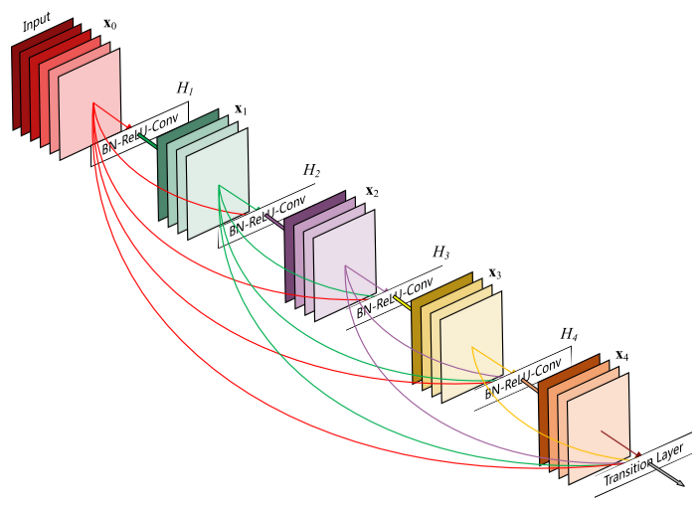

We will use this pretrained network to train our model


In [ ]:
model_ft = models.resnet50(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

## Train and Evaluate 




In [ ]:
#******* YOUR CODE STARTS HERE *********************
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)
# ****** YOUR CODE ENDS HERE ***********************

Epoch 0/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.4952 Acc: 0.7090
val Loss: 0.1487 Acc: 0.9216
Saving the model and best model weights

Epoch 1/24
----------
train Loss: 0.5208 Acc: 0.8156
val Loss: 0.5917 Acc: 0.7582

Epoch 2/24
----------
train Loss: 0.6122 Acc: 0.7541
val Loss: 0.2329 Acc: 0.9412
Saving the model and best model weights

Epoch 3/24
----------
train Loss: 0.6469 Acc: 0.7459
val Loss: 0.2328 Acc: 0.9346

Epoch 4/24
----------
train Loss: 0.5788 Acc: 0.7910
val Loss: 0.5206 Acc: 0.8562

Epoch 5/24
----------
train Loss: 0.6197 Acc: 0.7828
val Loss: 0.4593 Acc: 0.8301

Epoch 6/24
----------
train Loss: 0.4236 Acc: 0.8320
val Loss: 0.3006 Acc: 0.8954

Epoch 7/24
----------
train Loss: 0.3608 Acc: 0.8566
val Loss: 0.2199 Acc: 0.9412

Epoch 8/24
----------
train Loss: 0.3105 Acc: 0.8852
val Loss: 0.2238 Acc: 0.9412

Epoch 9/24
----------
train Loss: 0.2131 Acc: 0.9098
val Loss: 0.2320 Acc: 0.9346

Epoch 10/24
----------
train Loss: 0.3044 Acc: 0.9057
val Loss: 0.1972 Acc: 0.9412

Epoch 11/24
----------
train

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


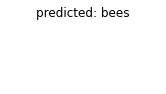

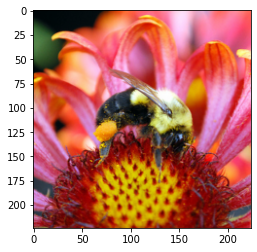

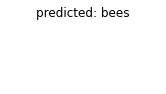

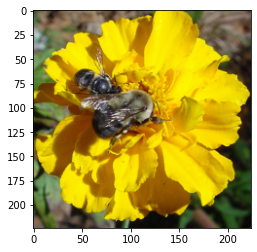

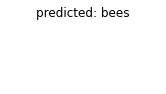

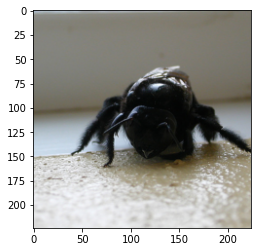

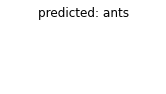

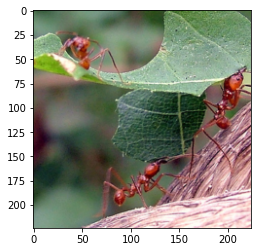

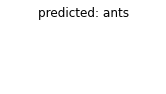

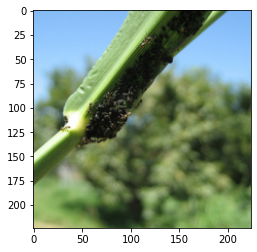

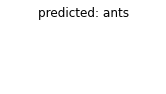

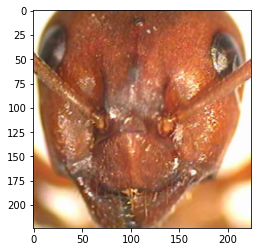

In [ ]:
visualize_model(model_ft)
plt.ioff()
plt.show()



ConvNet as fixed feature extractor
----------------------------------

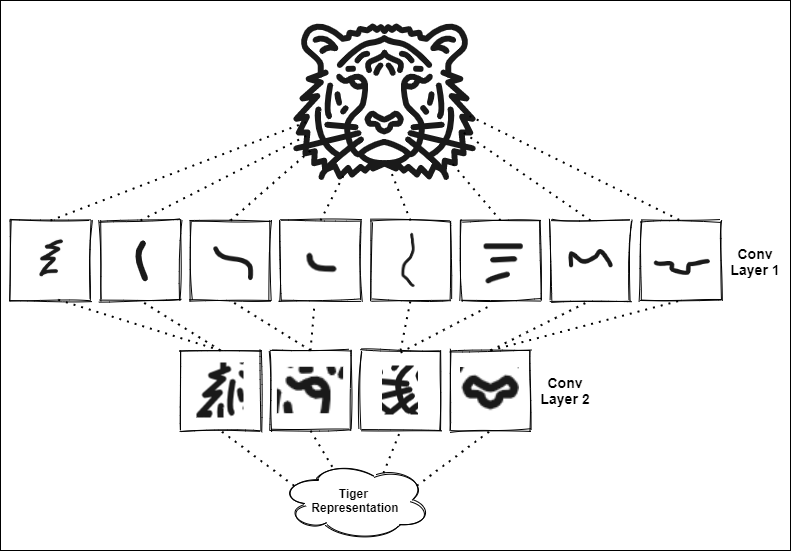

Use the representations learned by a previous network to extract meaningful features from new samples. We simply add a new classifier, which will be trained from scratch, on top of the pretrained model so that you can repurpose the feature maps learned previously for the dataset.

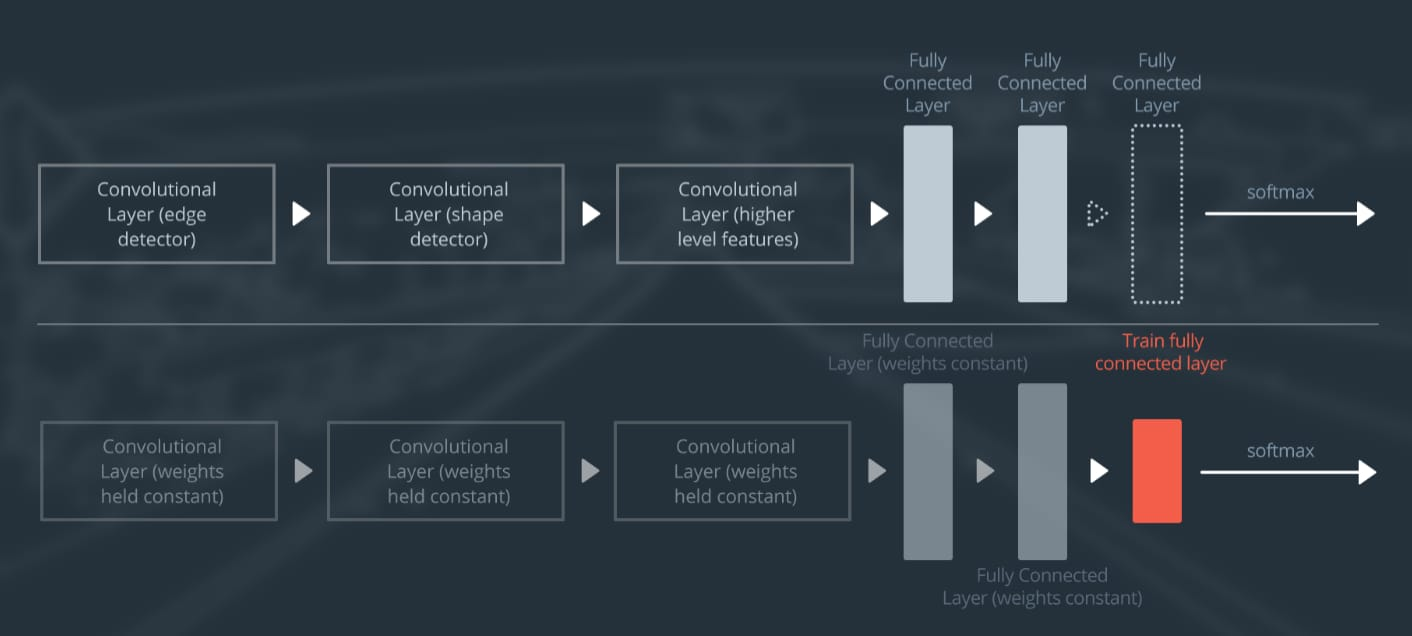

We do not need to (re)train the entire model. The base convolutional network already contains features that are generically useful for classifying pictures. However, the final, classification part of the pretrained model is specific to the original classification task, and subsequently specific to the set of classes on which the model was trained.
Here, we need to freeze all the network except the final layer. We need
to set ``requires_grad == False`` to freeze the parameters so that the
gradients are not computed in ``backward()``.





In [ ]:
model_conv = torchvision.models.resnet50(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.

#******* YOUR CODE STARTS HERE *************
optimizer_conv =  optim.SGD(model_conv.parameters(), lr = 0.001, momentum=0.9) # optimizer code

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)  # LR scheduler
#******** YOUR CODE ENDS HERE **************

## Train and evaluate

This training process will converge faster, as compared to previous training process, but, **WHY??**



In [ ]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

In [ ]:
visualize_model(model_conv)

plt.ioff()
plt.show()